In [0]:
## Import local library
import os
from datetime import datetime

## Import GeoPandas
import geopandas as gpd

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, expr, broadcast, udf, lit, struct

## Import Apache Sedona
from sedona.spark import *

# Create sedona session

In [0]:
config = SedonaContext. \
    builder(). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()
sedona = SedonaContext.create(config)

In [0]:
sc = sedona.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

# Use the prefix in all your DBFS path

If you use DBFS, Databricks requires that all paths must be absolute. You can use the variable below as the prefix for all paths.

In [0]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else '/'

print(PATH_PREFIX)

/


# Load taxi pickup records to Sedona

In [0]:
taxidf = sedona.read.format('csv').option("header","true").option("delimiter", ",").load("s3a://wherobots-examples/data/nyc-taxi-data.csv")
taxidf = taxidf.selectExpr('ST_Point(CAST(Start_Lon AS Decimal(24,20)), CAST(Start_Lat AS Decimal(24,20))) AS pickup', 'Trip_Pickup_DateTime', 'Payment_Type', 'Fare_Amt')
taxidf = taxidf.filter(col("pickup").isNotNull())
taxidf.show()
taxidf.createOrReplaceTempView('taxiDf')
taxiRdd = Adapter.toSpatialRdd(taxidf, "pickup")
import shutil
shutil.rmtree(PATH_PREFIX + "taxi-pickup.geojson", ignore_errors=True)
commit_path = PATH_PREFIX + "taxi-pickup.geojson"
dbutils.fs.rm(commit_path, True)
taxiRdd.saveAsGeoJSON(commit_path)

+--------------------+--------------------+------------+--------+
|              pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+--------------------+--------------------+------------+--------+
|POINT (-73.991957...|         1/4/09 2:52|        CASH|     8.9|
|POINT (-73.982102...|         1/4/09 3:31|      Credit|    12.1|
|POINT (-74.002587...|        1/3/09 15:43|      Credit|    23.7|
|POINT (-73.974267...|        1/1/09 20:52|      CREDIT|    14.9|
|POINT (-74.00158 ...|       1/24/09 16:18|        CASH|     3.7|
|POINT (-73.989806...|       1/16/09 22:35|        CASH|     6.1|
|POINT (-73.98405 ...|        1/21/09 8:55|      CREDIT|     5.7|
|POINT (-73.992635...|         1/4/09 4:31|        CASH|     6.1|
|POINT (-73.96969 ...|        1/5/09 16:29|      Credit|     8.7|
|POINT (-73.955173...|        1/5/09 18:53|        Cash|     5.9|
|POINT (-73.986824...|         1/5/09 8:15|        Cash|     2.9|
|POINT (-74.0061 4...|         1/5/09 6:21|        Cash|     7.7|
|POINT (-7

# Load Zones to Sedona

In [0]:
zoneDf = sedona.read.format('csv').option("delimiter", ",").load("s3a://wherobots-examples/data/TIGER2018_ZCTA5.csv")
zoneDf = zoneDf.selectExpr('ST_GeomFromWKT(_c0) as zone', '_c1 as zipcode')
zoneDf.show()
zoneDf.createOrReplaceTempView('zoneDf')

+--------------------+-------+
|                zone|zipcode|
+--------------------+-------+
|POLYGON ((-74.213...|  10312|
|POLYGON ((-74.164...|  10308|
|POLYGON ((-74.271...|  07077|
|POLYGON ((-74.169...|  10306|
|POLYGON ((-74.269...|  07064|
|POLYGON ((-74.254...|  07008|
|POLYGON ((-74.212...|  10314|
|POLYGON ((-74.101...|  10305|
|POLYGON ((-74.294...|  07001|
|POLYGON ((-74.013...|  11224|
|POLYGON ((-74.122...|  10304|
|POLYGON ((-74.014...|  11214|
|POLYGON ((-73.986...|  11223|
|POLYGON ((-74.305...|  07065|
|MULTIPOLYGON (((-...|  07036|
|MULTIPOLYGON (((-...|  10301|
|POLYGON ((-74.027...|  11228|
|POLYGON ((-74.041...|  11209|
|POLYGON ((-74.182...|  10311|
|POLYGON ((-74.026...|  11425|
+--------------------+-------+
only showing top 20 rows



# Visualize Sedona Dataframes on maps

In [0]:
zoneGpd = gpd.GeoDataFrame(zoneDf.toPandas(), geometry="zone")
taxiGpd = gpd.GeoDataFrame(taxidf.toPandas(), geometry="pickup")

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field zone. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pickup. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
At

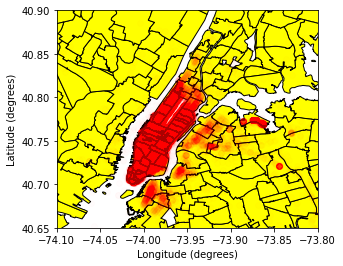

In [0]:
zone = zoneGpd.plot(color='yellow', edgecolor='black', zorder=1)
zone.set_xlabel('Longitude (degrees)')
zone.set_ylabel('Latitude (degrees)')

# Local view
zone.set_xlim(-74.1, -73.8)
zone.set_ylim(40.65, 40.9)

taxi = taxiGpd.plot(ax=zone, alpha=0.01, color='red', zorder=3)

# Find taxis in each zone

In [0]:
taxiVsZone = sedona.sql('SELECT zone, zipcode, pickup, Fare_Amt FROM zoneDf, taxiDf WHERE ST_Contains(zone, pickup)')
taxiVsZone.show()
taxiVsZone.createOrReplaceTempView("taxiVsZone")
taxiVsZone = taxiVsZone.cache()

+--------------------+-------+--------------------+--------+
|                zone|zipcode|              pickup|Fare_Amt|
+--------------------+-------+--------------------+--------+
|POLYGON ((-73.997...|  10002|POINT (-73.991957...|     8.9|
|POLYGON ((-73.993...|  10010|POINT (-73.982102...|    12.1|
|POLYGON ((-74.015...|  10014|POINT (-74.002587...|    23.7|
|POLYGON ((-73.988...|  10024|POINT (-73.974267...|    14.9|
|POLYGON ((-74.016...|  10013|POINT (-74.00158 ...|     3.7|
|POLYGON ((-73.999...|  10003|POINT (-73.989806...|     6.1|
|POLYGON ((-73.987...|  10016|POINT (-73.98405 ...|     5.7|
|POLYGON ((-74.008...|  10001|POINT (-73.992635...|     6.1|
|POLYGON ((-73.981...|  10017|POINT (-73.96969 ...|     8.7|
|MULTIPOLYGON (((-...|  10128|POINT (-73.955173...|     5.9|
|POLYGON ((-74.006...|  10018|POINT (-73.986824...|     2.9|
|POLYGON ((-74.012...|  10011|POINT (-74.0061 4...|     7.7|
|POLYGON ((-73.987...|  10016|POINT (-73.983339...|     7.3|
|POLYGON ((-73.977...|  

# Count taxis per zone

In [0]:
taxiPerZone = sedona.sql("SELECT zone, zipcode, count(*) as count, avg(Fare_Amt) as avg_fare FROM taxiVsZone c GROUP BY zone, zipcode")
taxiPerZone.show()
taxiPerZoneRdd = Adapter.toSpatialRdd(taxiPerZone, "zone")
import shutil
shutil.rmtree(PATH_PREFIX + "taxi-per-zone.geojson", ignore_errors=True)
taxiPerZoneRdd.saveAsGeoJSON(PATH_PREFIX + "taxi-per-zone.geojson")

+--------------------+-------+-----+------------------+
|                zone|zipcode|count|          avg_fare|
+--------------------+-------+-----+------------------+
|POLYGON ((-74.101...|  07072|    2|               6.9|
|MULTIPOLYGON (((-...|  07002|    2|              5.55|
|POLYGON ((-73.973...|  10153|  118| 7.659322033898305|
|POLYGON ((-74.254...|  07008|    1|               9.7|
|POLYGON ((-73.927...|  11104|  144|11.440277777777778|
|POLYGON ((-74.000...|  11204|    7|12.528571428571427|
|POLYGON ((-73.873...|  11374|   16|11.350000000000001|
|POLYGON ((-73.978...|  10111|   59| 8.722033898305085|
|POLYGON ((-73.861...|  10461|    3|21.566666666666666|
|MULTIPOLYGON (((-...|  10035|  148|10.603378378378377|
|POLYGON ((-74.009...|  10279|   36|10.383333333333333|
|POLYGON ((-73.998...|  07010|    7| 8.557142857142857|
|MULTIPOLYGON (((-...|  10464|    2|               6.8|
|POLYGON ((-73.811...|  11432|   14|10.771428571428572|
|POLYGON ((-73.916...|  11207|    5|7.4799999999

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-2440345079840071>:6
      4 import shutil
      5 shutil.rmtree(PATH_PREFIX + "taxi-per-zone.geojson", ignore_errors=True)
----> 6 taxiPerZoneRdd.saveAsGeoJSON(PATH_PREFIX + "taxi-per-zone.geojson")

File /databricks/python/lib/python3.9/site-packages/sedona/core/SpatialRDD/spatial_rdd.py:351, in SpatialRDD.saveAsGeoJSON(self, path)
    345 def saveAsGeoJSON(self, path: str):
    346     """
    347 
    348     :param path:
    349     :return:
    350     """
--> 351     return self._srdd.saveAsGeoJSON(path)

File /databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py:1321, in JavaMember.__call__(self, *args)
   1315 command = proto.CALL_COMMAND_NAME +\
   1316     self.command_header +\
   1317     args_command +\
   1318     proto.END_COMMAND_PART
   1320 answer = self.gateway_client.send_command(comma

# Visualize the result on a map

In [0]:
gdf = gpd.GeoDataFrame(taxiPerZone.toPandas(), geometry="zone")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

result = gdf.plot(
    column="count",
    legend=True,
    cmap='OrRd',
    cax=cax,
    ax=ax
)

# Local view
result.set_xlim(-74.1, -73.8)
result.set_ylim(40.65, 40.9)